# Network Analysis with Python, Pandas, and NetworkX

Adapted from https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/

In [1]:
import networkx as nx


## Creating a Graph

In [2]:
# Creating a Graph 
G = nx.Graph() # Right now G is empty



In [3]:
# Add a node
G.add_node(1) 
G.add_nodes_from([2,3]) # You can also add a list of nodes by passing a list argument



In [4]:
# Add edges 
G.add_edge(1,2)



In [5]:
e = (2,3)
G.add_edge(*e) # * unpacks the tuple
G.add_edges_from([(1,2), (1,3)]) # Just like nodes we can add edges from a list

__In addition to constructing graphs node-by-node or edge-by-edge, they can also be generated by applying classic graph operations, such as:__

* subgraph(G, nbunch)      - induced subgraph view of G on nodes in nbunch
* union(G1,G2)             - graph union
* disjoint_union(G1,G2)    - graph union assuming all nodes are different
* cartesian_product(G1,G2) - return Cartesian product graph
* compose(G1,G2)           - combine graphs identifying nodes common to both
* complement(G)            - graph complement
* create_empty_copy(G)     - return an empty copy of the same graph class
* convert_to_undirected(G) - return an undirected representation of G
* convert_to_directed(G)   - return a directed representation of G

## Accessing edges and nodes

In [6]:
#Nodes and Edges can be accessed together using the G.nodes() and G.edges() methods. 
# Individual nodes and edges can be accessed using the bracket/subscript notation.

G.nodes()

NodeView((1, 2, 3))

In [7]:
G.edges()

EdgeView([(1, 2), (1, 3), (2, 3)])

In [8]:
G[1] # same as G.adj[1]

AtlasView({2: {}, 3: {}})

In [9]:
G[1][2]

{}

In [10]:
G.edges[1, 2]

{}

## Graph Visualization

* Networkx provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. 
* Matplotlib offers some convenience functions. 
* GraphViz is probably the best tool for us as it offers a Python interface in the form of PyGraphViz.

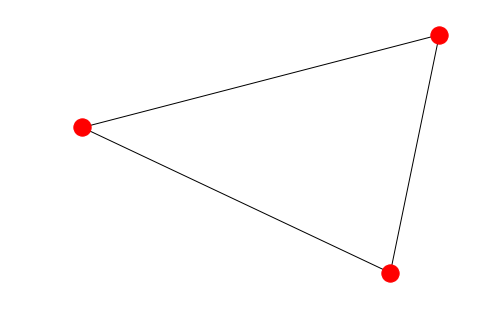

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
nx.draw(G)

To run the code below, you will first have to Install _Graphviz_
* pip install pygraphviz (for Python 2.7)
* pip3 install pygraphviz (for Python 3.x)
* conda install pygraphviz (for Anaconda /iPython)

In [12]:
import pygraphviz as pgv
d={'1': {'2': None}, '2': {'1': None, '3': None}, '3': {'1': None}}
A = pgv.AGraph(data=d)
print(A) # This is the 'string' or simple representation of the Graph


strict graph "" {
	1 -- 2;
	2 -- 3;
	3 -- 1;
}



In [19]:
# Let us create another Graph where we can individually control the colour of each node
B = pgv.AGraph()

# Setting node attributes that are common for all nodes 
B.node_attr['style']='filled'
B.node_attr['shape']='circle'
B.node_attr['fixedsize']='true'
B.node_attr['fontcolor']='#FFFFFF'

# Creating and setting node attributes that vary for each node (using a for loop)
for i in range(16):
 B.add_edge(0,i)
 n=B.get_node(i)
 n.attr['fillcolor']="#%2x0000"%(i*16)
 n.attr['height']="%s"%(i/16.0+0.5)
 n.attr['width']="%s"%(i/16.0+0.5)
B.draw('star.png',prog="circo") # This creates a .png file in the local directory. 


<img src='star.png'>

## Network analysis with a dataset 

* The dataset we will be looking at comes from the Airlines Industry. 
* It has some basic information on the Airline routes. 
* There is a Source of a flight and a destination. 
* There are also a few columns indicating arrival and departure times for each flight.

__The questions we would like to answer__

* What is the shortest way to get from A to B? In terms of distance and in terms of time
* Is there a way to go from C to D?
* Which airports have the heaviest traffic?
* Which airport in “in between” most other airports? (Can it be converted into a local hub)?

In [26]:
import pandas as pd 
import numpy as np

df = pd.read_csv('airlines.csv')


In [27]:
df.shape

(100, 16)

In [28]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance
0,2013,2,26,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946
1,2013,8,17,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076
2,2013,2,13,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402
3,2013,4,11,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626
4,2013,8,5,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422


* Origin and destination look like good choices for Nodes. 
* Everything can become either node or edge attributes. 
* A single edge is a flight with the following attributes:
    * Various times
    * Flight number
    * An airplane tail number
    * Etc...
* Notice that the year, month, day and time information is spread over many columns. We want to create one datetime column containing all of this information. 
* We also need to keep scheduled and actual time of arrival and departure separate.
* The time columns are not in a proper format. 
    * 4:30 pm is represented as 1630 instead of 16:30. 
    * There is no delimiter to split that column. 
    * Note that sched_dep_time and sched_arr_time are int64 dtype and dep_time and arr_time are float64 dtype
    * An additional complication is NaN values

In [41]:
# converting sched_dep_time to 'std' - Scheduled time of departure
df['std'] = df.sched_dep_time.astype(str).str.replace('(\d{2}$)', '') + ':' + df.sched_dep_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [42]:
# converting sched_arr_time to 'sta' - Scheduled time of arrival
df['sta'] = df.sched_arr_time.astype(str).str.replace('(\d{2}$)', '') + ':' + df.sched_arr_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [43]:
# converting dep_time to 'atd' - Actual time of departure
df['atd'] = df.dep_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + df.dep_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'


In [44]:
# converting arr_time to 'ata' - Actual time of arrival
df['ata'] = df.arr_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + df.arr_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [45]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,std,sta,atd,ata
0,2013,2,26,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946,16:30:00,18:37:00,18:07:00,19:56:00
1,2013,8,17,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076,14:45:00,17:47:00,14:59:00,18:01:00
2,2013,2,13,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402,18:15:00,21:25:00,18:12:00,20:55:00
3,2013,4,11,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626,21:15:00,23:53:00,21:22:00,23:39:00
4,2013,8,5,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422,18:35:00,21:55:00,18:32:00,21:45:00


In [47]:
# Combine the year, month and day columns into a date column. This is not an absolutely necessary step. But we can easily obtain the year, month and day (and other) information once it is converted into datetime format.

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [53]:
# Finally we drop the columns we don't need
df.drop(['year', 'month', 'day'], axis=1, inplace=True)


In [55]:
import networkx as nx
flight_graph = nx.from_pandas_edgelist(data, source='origin', target='dest', edge_attr=True,)


In [56]:
flight_graph.nodes()

NodeView(('EWR', 'MEM', 'LGA', 'FLL', 'SEA', 'JFK', 'DEN', 'ORD', 'MIA', 'PBI', 'MCO', 'CMH', 'MSP', 'IAD', 'CLT', 'TPA', 'DCA', 'SJU', 'ATL', 'BHM', 'SRQ', 'MSY', 'DTW', 'LAX', 'JAX', 'RDU', 'MDW', 'DFW', 'IAH', 'SFO', 'STL', 'CVG', 'IND', 'RSW', 'BOS', 'CLE'))

In [58]:
flight_graph.edges()

EdgeView([('EWR', 'MEM'), ('EWR', 'SEA'), ('EWR', 'MIA'), ('EWR', 'ORD'), ('EWR', 'MSP'), ('EWR', 'TPA'), ('EWR', 'MSY'), ('EWR', 'DFW'), ('EWR', 'IAH'), ('EWR', 'SFO'), ('EWR', 'CVG'), ('EWR', 'IND'), ('EWR', 'RDU'), ('EWR', 'IAD'), ('EWR', 'RSW'), ('EWR', 'BOS'), ('EWR', 'PBI'), ('EWR', 'LAX'), ('EWR', 'MCO'), ('EWR', 'SJU'), ('LGA', 'FLL'), ('LGA', 'ORD'), ('LGA', 'PBI'), ('LGA', 'CMH'), ('LGA', 'IAD'), ('LGA', 'CLT'), ('LGA', 'MIA'), ('LGA', 'DCA'), ('LGA', 'BHM'), ('LGA', 'RDU'), ('LGA', 'ATL'), ('LGA', 'TPA'), ('LGA', 'MDW'), ('LGA', 'DEN'), ('LGA', 'MSP'), ('LGA', 'DTW'), ('LGA', 'STL'), ('LGA', 'MCO'), ('LGA', 'CVG'), ('LGA', 'IAH'), ('FLL', 'JFK'), ('SEA', 'JFK'), ('JFK', 'DEN'), ('JFK', 'MCO'), ('JFK', 'TPA'), ('JFK', 'SJU'), ('JFK', 'ATL'), ('JFK', 'SRQ'), ('JFK', 'DCA'), ('JFK', 'DTW'), ('JFK', 'LAX'), ('JFK', 'JAX'), ('JFK', 'CLT'), ('JFK', 'PBI'), ('JFK', 'CLE'), ('JFK', 'IAD'), ('JFK', 'BOS')])

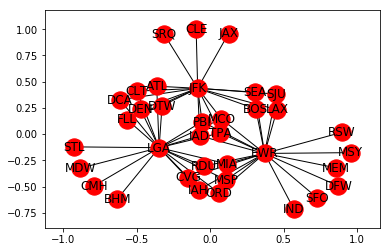

In [60]:
nx.draw_networkx(flight_graph, with_labels=True)

In [61]:

nx.algorithms.degree_centrality(flight_graph) 


{'ATL': 0.05714285714285714,
 'BHM': 0.02857142857142857,
 'BOS': 0.05714285714285714,
 'CLE': 0.02857142857142857,
 'CLT': 0.05714285714285714,
 'CMH': 0.02857142857142857,
 'CVG': 0.05714285714285714,
 'DCA': 0.05714285714285714,
 'DEN': 0.05714285714285714,
 'DFW': 0.02857142857142857,
 'DTW': 0.05714285714285714,
 'EWR': 0.5714285714285714,
 'FLL': 0.05714285714285714,
 'IAD': 0.08571428571428572,
 'IAH': 0.05714285714285714,
 'IND': 0.02857142857142857,
 'JAX': 0.02857142857142857,
 'JFK': 0.4857142857142857,
 'LAX': 0.05714285714285714,
 'LGA': 0.5714285714285714,
 'MCO': 0.08571428571428572,
 'MDW': 0.02857142857142857,
 'MEM': 0.02857142857142857,
 'MIA': 0.05714285714285714,
 'MSP': 0.05714285714285714,
 'MSY': 0.02857142857142857,
 'ORD': 0.05714285714285714,
 'PBI': 0.08571428571428572,
 'RDU': 0.05714285714285714,
 'RSW': 0.02857142857142857,
 'SEA': 0.05714285714285714,
 'SFO': 0.02857142857142857,
 'SJU': 0.05714285714285714,
 'SRQ': 0.02857142857142857,
 'STL': 0.0285714

In [64]:
# Average edge density of the Graphs
nx.density(flight_graph) 

0.09047619047619047

In [65]:
# Average shortest path length for ALL paths in the Graph
nx.average_shortest_path_length(flight_graph) 

2.36984126984127

* Calculate the shortest path algorithm by weighing the paths with either the distance or airtime. 
* Note that this is an approximate solution – the actual problem to solve is to calculate the shortest path factoring in the availability of a flight when you reach your transfer airport + wait time for the transfer. 
* For the purposes of this exercise we will just assume that is flight is readily available when you reach an airport and calculate the shortest path using the airtime as the weight

In [67]:
# Find all the paths available
for path in nx.all_simple_paths(flight_graph, source='JAX', target='DFW'):
    print(path)

['JAX', 'JFK', 'DEN', 'LGA', 'ORD', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'PBI', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'IAD', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MIA', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'RDU', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'TPA', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MSP', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MCO', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'CVG', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'IAH', 'EWR', 'DFW']
['JAX', 'JFK', 'SEA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'ORD', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'PBI', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'IAD', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'MIA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'RDU', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'TPA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'MSP', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'CVG', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'IAH', 'EWR', 'DFW']
['JAX', 'JFK',

In [68]:
# Dijkstra path from JAX to DFW.
# You can read more in-depth on how dijkstra works from: 
# https://courses.csail.mit.edu/6.006/fall11/lectures/lecture16.pdf
dijpath = nx.dijkstra_path(flight_graph, source='JAX', target='DFW')
dijpath


['JAX', 'JFK', 'SEA', 'EWR', 'DFW']

In [69]:
# Find the dijkstra path weighted by airtime (approximate case)
shortpath = nx.dijkstra_path(flight_graph, source='JAX', target='DFW', weight='air_time')
shortpath

['JAX', 'JFK', 'BOS', 'EWR', 'DFW']

## Bibliography and references:

This tutorial is largely based on an article titled "An Introduction to Graph Theory and Network Analysis" (https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/) 

* History of Graph Theory || S.G. Shrinivas et. al: http://www.cs.xu.edu/csci390/12s/IJEST10-02-09-124.pdf
* Networkx reference documentation: https://networkx.github.io/documentation/stable/reference/index.html
* Graphviz download: http://www.graphviz.org/download/
* Pygraphvix: http://pygraphviz.github.io/
* Star visualization: https://github.com/pygraphviz/pygraphviz/blob/master/examples/star.py
* Dijkstra Algorithm: https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm